### This notebook shows how to use recurrent neural network for one-step forecast of power consumption.

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'], index_col=0)

# sort dataframe
#df = df.sort_values(by='Datetime').reset_index(drop=True)
df.sort_index(inplace=True)

print(df.head())
print()
print(df.tail())

                     EKPC_MW
Datetime                    
2013-06-01 01:00:00   1166.0
2013-06-01 02:00:00   1098.0
2013-06-01 03:00:00   1036.0
2013-06-01 04:00:00   1023.0
2013-06-01 05:00:00    949.0

                     EKPC_MW
Datetime                    
2018-08-02 20:00:00   1815.0
2018-08-02 21:00:00   1769.0
2018-08-02 22:00:00   1756.0
2018-08-02 23:00:00   1619.0
2018-08-03 00:00:00   1448.0


# Explore data

In [3]:
print(df.info())
print()
print('shape', df.shape)
print('missing values', df['EKPC_MW'].isna().sum())
print('duplicated', sum(df.index.duplicated()))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45334 entries, 2013-06-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
EKPC_MW    45334 non-null float64
dtypes: float64(1)
memory usage: 708.3 KB
None

shape (45334, 1)
missing values 0
duplicated 4


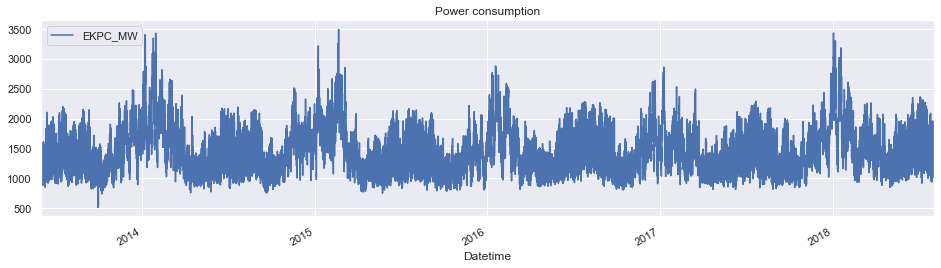

In [4]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Missing values treatment

In [5]:
# check missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

all_dates.difference(df.index)

DatetimeIndex(['2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [6]:
# missing values using reindexing and interpolation
df = df.loc[~df.index.duplicated(),:].reindex(all_dates).interpolate(method='linear')

print('missing values', df['EKPC_MW'].isna().sum())

missing values 0


# Create pipeline

In [7]:
# transformer function to encode calendar data  lambda x: int(x.day/7)
trans_func = lambda df: np.concatenate([df.index.month.values.reshape(-1,1),
                                        (df.index.day.values/7).astype(int).reshape(-1,1),
                                        df.index.weekday.values.reshape(-1,1),
                                        df.index.hour.values.reshape(-1,1)], axis=1)

# feature transformer pipeline
feature_transformer = make_pipeline(FunctionTransformer(func=trans_func), OneHotEncoder(sparse=False))

# target transformer
target_transformer = MinMaxScaler(feature_range=(-1, 1))

# Split data

In [8]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[:"2016-01-01"]
df_valid = df["2016-01-01":"2017-01-01"]
df_test = df["2017-01-01":]

# fit transformers on training data and perform transformations creating numpy arrays
# train data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

# validation data
X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

# test data
X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22679, 48) y_train = (22679, 1)
X_valid = (8808, 48) y_valid = (8808, 1)
X_test = (13897, 48) y_test = (13897, 1)


In [9]:
# organize data in a way suitable for tensorflow model
def get_data(x_vals, y_vals, Tx=24):

    x, y = [], []
    
    for i in range(Tx, x_vals.shape[0]-1):
        x.append( np.concatenate((x_vals[i-Tx:i,:], y_vals[i-Tx:i,:]), axis=1) )
        y.append([y_vals[i]])    
   
    # convert to numpy arrays and return    
    return np.array(x), np.array(y)

# get data sets for tensorflow
x_train_tf, y_train_tf = get_data(X_train, y_train)
x_valid_tf, y_valid_tf = get_data(X_valid, y_valid)
x_test_tf, y_test_tf = get_data(X_test, y_test)

# print shape of array
print('x_train_tf = {} y_train_tf = {}'.format(x_train_tf.shape, y_train_tf.shape))
print('x_valid_tf = {} y_valid_tf = {}'.format(x_valid_tf.shape, y_valid_tf.shape))
print('x_test_tf = {} y_test_tf = {}'.format(x_test_tf.shape, y_test_tf.shape))

x_train_tf = (22654, 24, 49) y_train_tf = (22654, 1, 1)
x_valid_tf = (8783, 24, 49) y_valid_tf = (8783, 1, 1)
x_test_tf = (13872, 24, 49) y_test_tf = (13872, 1, 1)


# Build tensorflow model

## Architecture: sequence to one model

<!--- -->
<img src="images/energy/seq2one_l2.png" width="700" height="400" style="float: center"/>

In [10]:
def build_model(nx, Tx=24):
    # inputs
    x = Input(shape=(Tx, nx))

    # layers
    o, _, _ = LSTM(64, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3))(x)
    _, h, _ = LSTM(64, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3))(o)
    y = Dense(1, activation='linear')(h)
    
    # model
    model = Model(inputs=x, outputs=y)
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    return model


# model
model = build_model(nx=x_train_tf.shape[2], Tx=24)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 49)]          0         
_________________________________________________________________
lstm (LSTM)                  [(None, 24, 64), (None, 6 29184     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 24, 64), (None, 6 33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 62,273
Trainable params: 62,273
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
fname_best_model = 'models/energy/onestep/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_model,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train model
history = model.fit(x_train_tf, y_train_tf, 
                    validation_data=(x_valid_tf, y_valid_tf), 
                    epochs=200, shuffle=False, callbacks=callbacks, verbose=0)

# Load the weights with the best error on validation data
model.load_weights(fname_best_model)

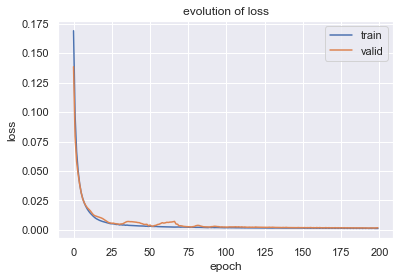

In [12]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [13]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# train data
y_train_true = target_transformer.inverse_transform( y_train_tf.reshape(-1, 1) )
y_train_pred = target_transformer.inverse_transform( model.predict(x_train_tf) )
print("Train data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = target_transformer.inverse_transform( y_valid_tf.reshape(-1, 1) )
y_valid_pred = target_transformer.inverse_transform( model.predict(x_valid_tf) )
print("Valid data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = target_transformer.inverse_transform( y_test_tf.reshape(-1, 1) )
y_test_pred = target_transformer.inverse_transform( model.predict(x_test_tf) )
print("Test data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MAPE=2.5732
Valid data: MAPE=2.5875
Test data: MAPE=2.5467


## Plot all forecasts

In [14]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

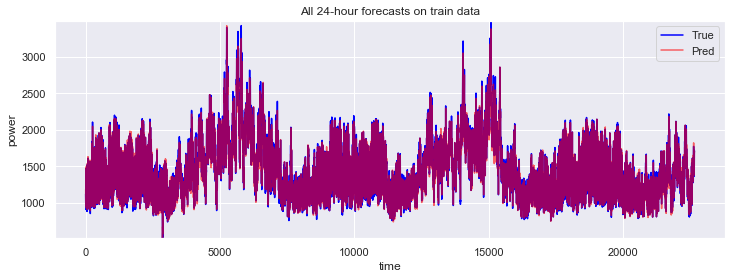

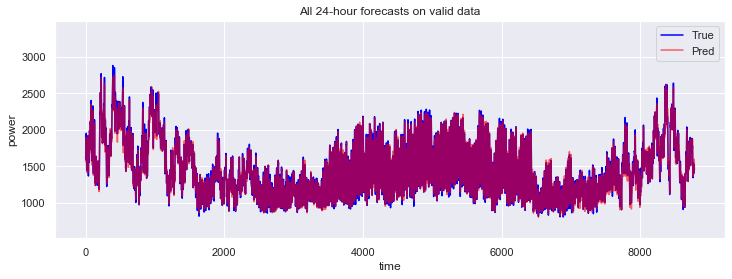

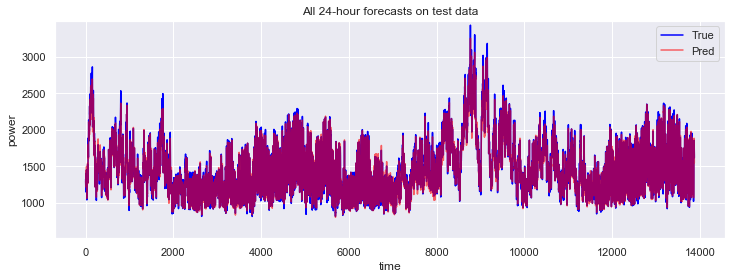

In [15]:
# plot the results
plot_predictions(y_train_true, y_train_pred, title='All 24-hour forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_valid_true, y_valid_pred, title='All 24-hour forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_test_true, y_test_pred, title='All 24-hour forecasts on test data', xlim=None, ylim=ylim)